In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import glob
import tqdm

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 42)

In [4]:
def preprocess(df,id,dir):
    sample = df[df.id == id]
    data_encode = np.reshape(list(map(int, sample.rle.values[0].split(" "))),(-1,2))
    height = sample.img_height.values[0]
    width = sample.img_width.values[0]
    mask = np.zeros((height*width,1))
    for i in range(len(data_encode)):
        mask[data_encode[i,0]:data_encode[i,0]+data_encode[i,1]] = 1
    mask = mask.reshape((width,height)).T
    PATH = f"{dir}/{id}.tiff"
    img = cv2.cvtColor(cv2.imread(PATH),cv2.COLOR_BGR2RGB)
    img = img.transpose((2,0,1))
    return img,mask

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

In [6]:
class FTUsDataset(Dataset):
    def __init__(self, df, image_dir):
        self.df = df
        self.image_dir = image_dir
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        id = self.df.iloc[idx,0]
        img,mask = preprocess(self.df,id,self.image_dir)
        sample = {'img': img, 'mask':mask}
        return sample

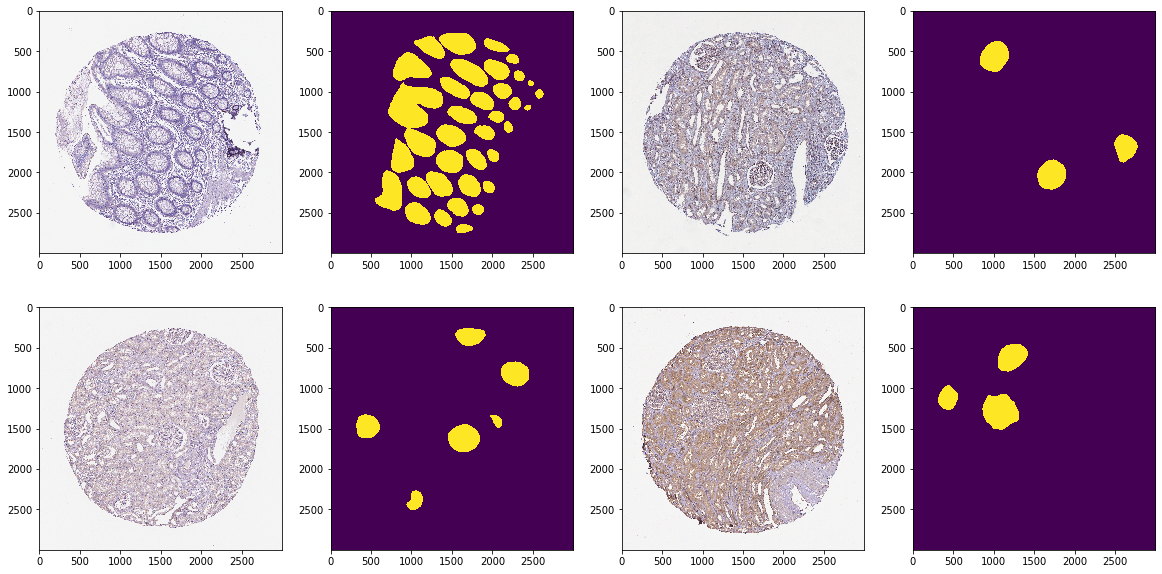

In [7]:
train_dataset = FTUsDataset(df_train,'train_images')
plt.figure(figsize = (20,10))
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    ax1 = plt.subplot(2,4,2*i+1)
    ax1.imshow(sample['img'].transpose((1,2,0)))
    ax2 = plt.subplot(2,4,2*i+2)
    ax2.imshow(sample['mask'])

    if i == 3:
        plt.show()
        break

In [8]:
val_dataset = FTUsDataset(df_val,'train_images')

In [9]:
train_loader = DataLoader(train_dataset,batch_size= 4, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= 4, shuffle= False)

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [11]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [12]:
import torchvision 

In [13]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs        = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [14]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        return out

In [15]:
model = UNet()
from torchsummary import summary

In [16]:
summary(model,(3,300,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 298, 298]           1,792
              ReLU-2         [-1, 64, 298, 298]               0
            Conv2d-3         [-1, 64, 296, 296]          36,928
              ReLU-4         [-1, 64, 296, 296]               0
             Block-5         [-1, 64, 296, 296]               0
         MaxPool2d-6         [-1, 64, 148, 148]               0
            Conv2d-7        [-1, 128, 146, 146]          73,856
              ReLU-8        [-1, 128, 146, 146]               0
            Conv2d-9        [-1, 128, 144, 144]         147,584
             ReLU-10        [-1, 128, 144, 144]               0
            Block-11        [-1, 128, 144, 144]               0
        MaxPool2d-12          [-1, 128, 72, 72]               0
           Conv2d-13          [-1, 256, 70, 70]         295,168
             ReLU-14          [-1, 256,

In [17]:
img, mask = preprocess(df_train,10044,'train_images')

In [26]:
patches = torch.Tensor(img).data.unfold(0,3,3).unfold(1,300,300).unfold(2,300,300)

In [27]:
patches = patches.contiguous().view(-1,3,300,300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


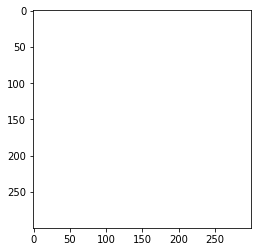

In [29]:
plt.imshow(patches[45,:,:,:].permute(1,2,0))

In [25]:
type(patches)

torch.Size

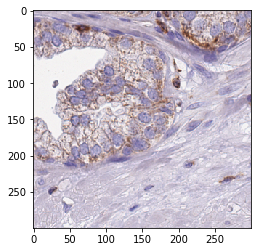

In [35]:
plt.imshow(patches[45,:,:,:].permute(1,2,0).to(torch.int32))

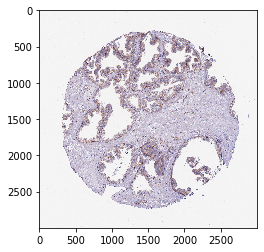

In [36]:
plt.imshow(img.transpose((1,2,0)))